# Explore here

In [20]:
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
archivo = 'https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv'
total_data  = pd.read_csv(archivo)
total_data.head(10)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
5,https://www.brookings.edu/interactives/reopeni...,False
6,https://www.reuters.com/investigates/special-r...,False
7,https://www.theatlantic.com/magazine/archive/2...,False
8,https://www.vox.com/2020/6/17/21294680/john-bo...,False
9,https://www.theguardian.com/travel/2020/jun/18...,False


### Preprocesamiento de datos

In [3]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)

total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [4]:
total_data.shape

(2999, 2)

In [5]:
# Ver duplicados
print("Análisis de duplicados:")

duplicados_exactos = total_data.duplicated().sum()
print(f"Duplicados exactos: {duplicados_exactos}")

# Ver solo duplicados en la columna de URL
duplicados_urls = total_data.duplicated(subset=['url']).sum()
print(f"URLs duplicadas: {duplicados_urls}")

# Ver si hay URLs iguales con diferentes etiquetas de Spam
total_data['url_lower'] = total_data['url'].str.lower()
conflictos = total_data.groupby('url_lower')['is_spam'].nunique()
conflictos = conflictos[conflictos > 1]
print(f"URLs con etiquetas contradictorias: {len(conflictos)}")

# Encuentra qué URLs tienen más duplicados
conteo_urls = total_data['url_lower'].value_counts()
urls_repetidas = conteo_urls[conteo_urls > 1]

print(f"URLs que aparecen más de una vez: {len(urls_repetidas)}")
print("\nTop 10 URLs más duplicadas:")
for url, count in urls_repetidas.head(10).items():
    # Muestra las etiquetas de cada URL duplicada
    etiquetas = total_data[total_data['url_lower'] == url]['is_spam'].unique()
    print(f"URL: {url[:50]}... | Veces: {count} | Etiquetas: {etiquetas}")

Análisis de duplicados:
Duplicados exactos: 630
URLs duplicadas: 630
URLs con etiquetas contradictorias: 0
URLs que aparecen más de una vez: 246

Top 10 URLs más duplicadas:
URL: https://www.bloomberg.com/tosv2.html... | Veces: 26 | Etiquetas: [1]
URL: https://www.hvper.com/... | Veces: 13 | Etiquetas: [1]
URL: https://briefingday.com/m/v4n3i4f3... | Veces: 13 | Etiquetas: [1]
URL: https://briefingday.com/fan... | Veces: 13 | Etiquetas: [1]
URL: https://briefingday.us8.list-manage.com/unsubscrib... | Veces: 13 | Etiquetas: [1]
URL: https://docs.google.com/forms/d/e/1faipqlscc99wwsu... | Veces: 11 | Etiquetas: [1]
URL: https://www.morningbrew.com/daily/r/... | Veces: 11 | Etiquetas: [1]
URL: https://www.morningbrew.com/daily/r... | Veces: 11 | Etiquetas: [1]
URL: https://www.morningbrew.com/daily/refer-a-friend... | Veces: 11 | Etiquetas: [1]
URL: https://www.morningbrew.com/... | Veces: 11 | Etiquetas: [1]


Dado que parece no haber ruido en el etiquetado de los url duplicados, se decide eliminarlos del dataset manteniendo únicamente la primera aparición.

In [6]:
# Eliminar duplicados
df_clean = total_data.drop_duplicates(keep='first')
total_data = total_data.drop('url_lower', axis=1)
df_clean = df_clean.drop('url_lower', axis=1)

print("✅ Duplicados eliminados manteniendo la primera aparición")
print(f"Dataset original: {total_data.shape}")
print(f"Dataset limpio: {df_clean.shape}")
print(f"Registros eliminados: {len(total_data) - len(df_clean)}")

✅ Duplicados eliminados manteniendo la primera aparición
Dataset original: (2999, 2)
Dataset limpio: (2369, 2)
Registros eliminados: 630


In [7]:
# Ver distribución de los datos
antes = total_data['is_spam'].value_counts(normalize=True)
despues = df_clean['is_spam'].value_counts(normalize=True)

print("Distribución ANTES:", antes)
print("Distribución DESPUÉS:", despues)

Distribución ANTES: is_spam
0    0.767923
1    0.232077
Name: proportion, dtype: float64
Distribución DESPUÉS: is_spam
0    0.897003
1    0.102997
Name: proportion, dtype: float64


#### Procesamiento del texto

In [8]:
def preprocess_text(text):
    # Eliminar https, www y dominios
    text = re.sub(r'https?://', " ", text)
    text = re.sub(r'www\.', ' ', text)
    text = re.sub(r'\.(com|net|org|es)', " ", text)

    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

In [9]:
df_clean["url"] = df_clean["url"].apply(preprocess_text)
df_clean.head()

,url,is_spam
0,"[briefingday, us, list, manage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, v, i]",1
3,"[briefingday, m, commentform]",0
4,"[briefingday, fan]",1


#### Lematización

In [10]:
# instancia lematizador
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    # lematiza
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # saca stop words
    tokens = [word for word in tokens if word not in stop_words]
    # se queda con las de largo mayor a
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df_clean["url"] = df_clean["url"].apply(lemmatize_text)
df_clean.head()

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",1
1,[hvper],1
2,[briefingday],1
3,"[briefingday, commentform]",0
4,[briefingday],1


#### Vectorización

In [12]:
tokens_list = df_clean["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df_clean["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 538))

### Modelo SVM

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = SVC(kernel = "linear", random_state = 42)

model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [14]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [15]:
print(f'El accuracy en train es: {accuracy_score(y_train, y_pred_train)}')
print(f'El accuracy en test es: {accuracy_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

El accuracy en train es: 0.9372031662269129
El accuracy en test es: 0.9514767932489452
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.83      0.51      0.63        39

    accuracy                           0.95       474
   macro avg       0.90      0.75      0.80       474
weighted avg       0.95      0.95      0.95       474



Text(0.5, 1.0, 'Matriz de confusión')

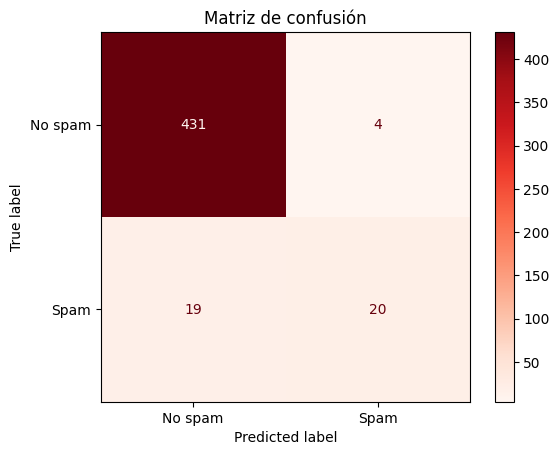

In [16]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['No spam', 'Spam'])
disp.plot(cmap = 'Reds')
plt.title("Matriz de confusión")

### Optimización de hiperparámetros
Ya que el datset está desbalanceado con un 89% de No spam frente a un 11% de Spam se aplicará GridSearch junto a StratifiedKFold para oprimizar la búsqueda de los mejores hiperparámetros, dándole folds más representativos de las proporciones reales del datset.
Del mismo modo se fijará F1 como score para ver realmente la cpacidad del modelo para predecir spam.

In [17]:
# Configurar StratifiedKFold para mantener proporción de clases
cv_strategy = StratifiedKFold(
    n_splits=5,       
    shuffle=True,      
    random_state=42    
)

# Definir el modelo y parámetros
model = SVC(kernel="linear", random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],           
    'class_weight': [None, 'balanced', {0: 1, 1: 3}]  # Manejo de desbalance
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv_strategy,                    
    scoring='f1',                      # Métrica principal para desbalance
    n_jobs=-1,                         
    verbose=2,                         
    return_train_score=True            # Para análisis posterior
)
# Ajustar al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END ...........................C=0.1, class_weight=None; total time=   0.3s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.3s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.2s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.3s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.3s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.7s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.7s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.7s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.7s
[CV] END ...................C=0.1, class_weight={0: 1, 1: 3}; total time=   0.5s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.7s
[CV] END ...................C=0.1, class_weight={0: 1, 1: 3}; total time=   0.4s
[CV] END ...................

,estimator,SVC(kernel='l...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': [None, 'balanced', ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,C,0.1


In [18]:
# Obtener los mejores resultados
print("MEJORES PARÁMETROS ENCONTRADOS:")
print(f"   {grid_search.best_params_}")
print(f"Mejor F1-score (validación): {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejor modelo: {best_model}")

MEJORES PARÁMETROS ENCONTRADOS:
   {'C': 0.1, 'class_weight': 'balanced'}
Mejor F1-score (validación): 0.6185
Mejor modelo: SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=42)



📈 RESULTADOS EN TEST:
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       435
           1       0.58      0.72      0.64        39

    accuracy                           0.93       474
   macro avg       0.78      0.84      0.80       474
weighted avg       0.94      0.93      0.94       474

MATRIZ DE CONFUSIÓN:
[[431   4]
 [ 19  20]]
F1-SCORE EN TRAIN: 0.6775
F1-SCORE EN TEST: 0.6437
Accuracy en TRAIN: 0.9266490765171504
Accuracy en TEST: 0.9345991561181435


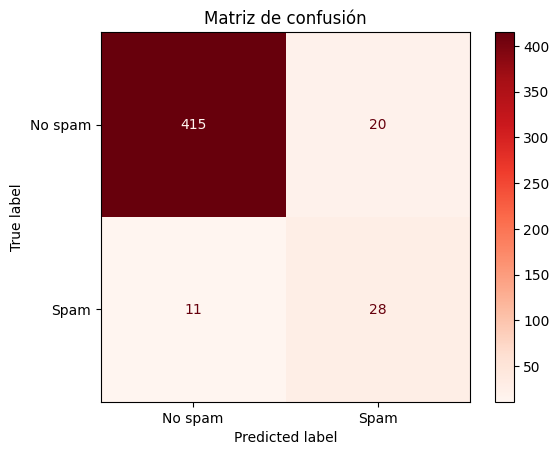

In [19]:
y_pred_train_b = best_model.predict(X_train)
y_pred_test_b = best_model.predict(X_test)

print("\n📈 RESULTADOS EN TEST:")

# Classification report
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_test_b))

# Matriz de confusión
print("MATRIZ DE CONFUSIÓN:")
cm2 = confusion_matrix(y_test, y_pred_test_b)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=['No spam', 'Spam'])
disp2.plot(cmap = 'Reds')
plt.title("Matriz de confusión")
print(cm)

# F1-score específico
test_f1 = f1_score(y_test, y_pred_test_b)
train_f1 = f1_score(y_train, y_pred_train_b)
print(f"F1-SCORE EN TRAIN: {train_f1:.4f}")
print(f"F1-SCORE EN TEST: {test_f1:.4f}")

# Accuracy en mejor modelo
print(f'Accuracy en TRAIN: {accuracy_score(y_train, y_pred_train_b)}')
print(f'Accuracy en TEST: {accuracy_score(y_test, y_pred_test_b)}')

### Conclusión
El modelo generaliza perfectamente ya que no hay overfitting. El accuracy muy alto (93.5%) indica que tiene un buen rendimiento general. Detecta el 72% del spam real (basado en el recall-score), lo que significa que la mayoría del contenido no deseado es identificado correctamente. Solo un 4.4% (los falsos positivos) de URLs legítimas son bloqueadas incorrectamente, manteniendo un buen equilibrio entre seguridad y usabilidad.

### Guardado del modelo

In [21]:
with open("../models/SVM_regularizado.sav", "wb") as f:
    pickle.dump(best_model, f)